<a href="https://colab.research.google.com/github/bhagirathtallapragada/Secure-AI-project--Implementing-adversarial-attacks-and-defenses-using-ART/blob/main/spai_project_all_defenses_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install adversarial-robustness-toolbox==1.7.1

In [ ]:
# only for adversarial training defence. Use version 1.7.1 for all other implementations
!pip install adversarial-robustness-toolbox 

     |████████████████████████████████| 1.1 MB 26.7 MB/s 
     |████████████████████████████████| 3.3 MB 47.5 MB/s 
     |████████████████████████████████| 26.3 MB 83 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
# mounting the drive to store the results

from google.colab import drive
drive.mount('/content/drive') #, force_remount = True)

Mounted at /content/drive


# Setting up the dataset and the model

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import Model
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
# from keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Reshape
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import classification_report
import pickle
import os

from art.estimators.classification import TensorFlowV2Classifier
from art.estimators.classification import KerasClassifier

In [ ]:
tf.compat.v1.enable_eager_execution()

In [ ]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

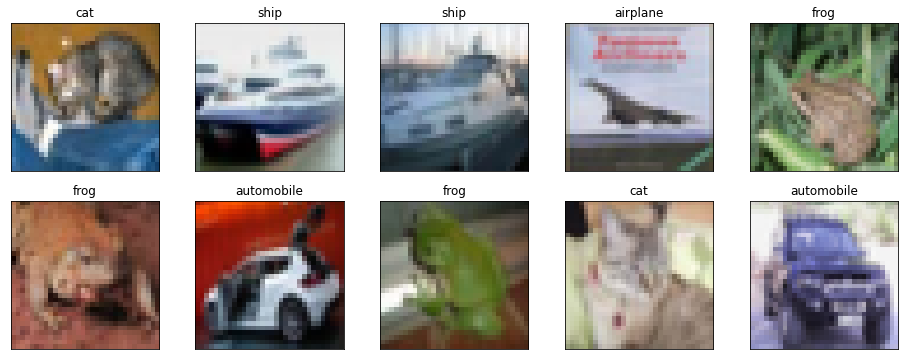

In [ ]:
# visualizing a few sample images

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure(figsize=(16,6))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    im = x_test[i, :]
    ax.set_title(class_names[y_test[i][0]])
    plt.imshow(im)
plt.show()

In [ ]:
# checking the format of data
print(type(x_train[0]))
print(x_train[0].shape)

# retaining the original format for the test data
x_test_retained=x_test.copy()

# Convert class vectors to binary class matrices.
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_train = tf.keras.utils.to_categorical(y_train, 10)

print(y_test.shape)
print(y_train.shape)

# Normalizing the data by converting to float and dividing by 255 (max value for r,g,b)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

# print(x_train[0])

<class 'numpy.ndarray'>
(32, 32, 3)
(10000, 10)
(50000, 10)


In [ ]:
# # using keras to load the given model
hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier.add(hub.KerasLayer(hub_url, signature='default'))
classifier.add(tf.keras.layers.Activation('softmax'))

classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
print(classifier.summary())
# tf.keras.utils.plot_model(model, "my_first_model.png")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 10)                7796426   
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________
None


In [ ]:
# evaluating with a subset of training data. The expected accuracy is 1 since this is model is trained on Cifar10

tf.config.run_functions_eagerly(True)
x_train_trial=x_train[0:1000].copy()
y_train_trial=y_train[0:1000].copy()
classifier.evaluate(x_train_trial, y_train_trial)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 11s 326ms/step - loss: 0.0017 - accuracy: 1.0000


[0.0016680299304425716, 1.0]

8


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


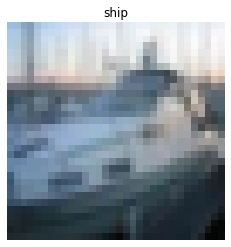

In [ ]:
# Visualizing a prediction using the non scaled and retained test data saved earlier

prediction = classifier.predict(x_test[:3])
ans = np.argmax(prediction[2])
print(ans)

plt.imshow(x_test_retained[2])
plt.axis( 'off' )
plt.title(class_names[ans])
plt.show( )

### Defining classifier 2 with the same model to create the evasion attack

In [ ]:
# # using keras to load the given model
hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier2 = tf.keras.Sequential()
classifier2.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier2.add(hub.KerasLayer(hub_url, signature='default'))
classifier2.add(tf.keras.layers.Activation('softmax'))

classifier2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
# function to generate the needed samples for implementing attack

def candidate_data(x_test, y_test, n):
  cx_test=[]
  cy_test=[]
  
  for i in list(range(y_test.shape[1])):
    id = y_test[:,i]==1
    cx_test.append(x_test[id][:n].copy())
    cy_test.append(y_test[id][:n].copy())

  cx_test = np.concatenate(cx_test)
  cy_test = np.concatenate(cy_test)

  return cx_test, cy_test

Implementing a helper function to implement attacks

In [ ]:
def implement_attack(classifier, attack, sample_test, test_labels, attack_name):
  # generate the adverserial examples
  x_test_adv = attack.generate(sample_test)
  performance_metrics=classifier.evaluate( x_test_adv, test_labels)
  predictions=classifier.predict(x_test_adv)
  report = classification_report(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1), output_dict=True)

  report=report['weighted avg']
  report.update({'Loss':performance_metrics[0]})
  report.update({'Accuracy':performance_metrics[1]})
  report.update({'Attack':attack_name})

  return report, x_test_adv, predictions

# Implementing pre processor attacks

## Feature Squeezing

In [ ]:
from art.defences.preprocessor import FeatureSqueezing

In [ ]:
fs_def = FeatureSqueezing(clip_values=(0,1), bit_depth=16, apply_fit = True, apply_predict = False)

In [ ]:
x_def,y_def = fs_def.__call__(x=x_train,y=y_train)

We train the model with the defensive samples generated above

In [ ]:
classifier.fit(x_def,y_def)

1563/1563 [==============================] - 583s 372ms/step - loss: 0.0018 - accuracy: 1.0000


In [ ]:
# Create a ART TensorFlow v2 classifier for the target TensorFlow model for the fgsm attack
artclassifier2 = TensorFlowV2Classifier(model=classifier2, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier2.loss, 
                                    clip_values=(0, 1), channels_first=False)

Impementing evasion attack and generating the adverserial samples on classifier2 (non defensively robust)

In [ ]:
# White box evasion attack

from art.attacks.evasion import FastGradientMethod

sample_test, sample_label=candidate_data(x_test, y_test, 10)
fgsm_attack = FastGradientMethod(artclassifier2, targeted=False, eps_step=0.001, eps=0.01)

# report, x_test_adv, predictions = implement_attack(classifier, fgsm_attack, sample_test=sample_test, test_labels=sample_label, attack_name='fgsm attack on defensively trained model')
# perturbation = np.mean(np.abs((x_test_adv - sample_test)))
# report['perturbation']=perturbation

# collective_res[report['Attack']]=report
# generate adverserial samples
x_test_adv=fgsm_attack.generate(sample_test)

# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 197ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228835105895996, 0.4000000059604645]


In [ ]:
collective_res={}
collective_res['fgsm attack on defensively trained model (feature squeezing)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res)

{'fgsm attack on defensively trained model (feature squeezing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}}


In [ ]:
# save the results dictionary in a pickle file
f = open("/content/drive/MyDrive/spai/defense_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

In [ ]:
# check to see if everything stored properly
file_to_read = open("/content/drive/MyDrive/spai/defense_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
print(collective_res)

{'fgsm attack on defensively trained model (feature squeezing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}}


In [ ]:
# Trying Jacobian Saliency map attack
from art.attacks.evasion import SaliencyMapMethod

sample_test, sample_label=candidate_data(x_test, y_test, 10)
jsm_attack = SaliencyMapMethod(artclassifier2, theta=0.1, gamma=1.0, batch_size=20)

x_test_adv=jsm_attack.generate(sample_test)

# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

JSMA:   0%|          | 0/5 [00:00<?, ?it/s]

4/4 [==============================] - 1s 272ms/step - loss: 1.2060 - accuracy: 0.0100
loss & accuracy on adversarial examples:  [1.2059839963912964, 0.009999999776482582]


In [ ]:
collective_res={}
collective_res['jsm attack on defensively trained model (feature squeezing)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res)

{'jsm attack on defensively trained model (feature squeezing)': {'loss': 1.2059839963912964, 'accuracy': 0.009999999776482582}}


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/defense_results.pickle", "rb")

collective_res_pre = pickle.load(file_to_read)
file_to_read.close()
collective_res_pre['jsm attack on defensively trained model (feature squeezing)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res_pre)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/defense_results.pickle", "wb")
pickle.dump(collective_res_pre, f)
f.close()

{'fgsm attack on defensively trained model (feature squeezing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (JPEG compression)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (Gaussian data augmentation)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (spatial smoothing)': {'loss': 3.9228835105895996, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (total variance minimization)': {'loss': 3.9228835105895996, 'accuracy': 0.4000000059604645}, 'jsm attack on defensively trained model (feature squeezing)': {'loss': 1.2059839963912964, 'accuracy': 0.009999999776482582}}


## Gaussian Data Augmentation

In [ ]:
from art.defences.preprocessor import GaussianAugmentation
ga_def = GaussianAugmentation(sigma=0.02, augmentation=False, ratio=0.5, apply_predict=True)

In [ ]:
x_def,y_def = ga_def.__call__(x=x_train,y=y_train)

Load the model afresh

In [ ]:
# # using keras to load the given model
hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier.add(hub.KerasLayer(hub_url, signature='default'))
classifier.add(tf.keras.layers.Activation('softmax'))

classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

We train the model with the defensive samples generated above

In [ ]:
classifier.fit(x_def,y_def)

1563/1563 [==============================] - 507s 324ms/step - loss: 0.0473 - accuracy: 0.9854


In [ ]:
# Create a ART TensorFlow v2 classifier for the target TensorFlow model
# Create a ART Keras classifier for the target TensorFlow model
artclassifier2 = TensorFlowV2Classifier(model=classifier2, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier2.loss, 
                                    clip_values=(0, 1), channels_first=False)
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

# artclassifier2 = KerasClassifier(model=classifier2, clip_values=(0, 1), channels_first=False)

In [ ]:
# White box evasion attack

from art.attacks.evasion import FastGradientMethod

sample_test, sample_label=candidate_data(x_test, y_test, 10)
fgsm_attack = FastGradientMethod(artclassifier2, targeted=False, eps_step=0.001, eps=0.01)

# report, x_test_adv, predictions = implement_attack(classifier, fgsm_attack, sample_test=sample_test, test_labels=sample_label, attack_name='fgsm attack on defensively trained model')
# perturbation = np.mean(np.abs((x_test_adv - sample_test)))
# report['perturbation']=perturbation

# collective_res[report['Attack']]=report
# generate adverserial samples
x_test_adv=fgsm_attack.generate(sample_test)

# checking the performance of adverserial examples on the model trained with defensively robust samples 
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 233ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


In [ ]:
collective_res={}
collective_res['fgsm attack on defensively trained model (Gaussian Augmentation)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res)

{'fgsm attack on defensively trained model (Gaussian Augmentation)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}}


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/defense_results.pickle", "rb")

collective_res_pre = pickle.load(file_to_read)
file_to_read.close()
collective_res_pre['fgsm attack on defensively trained model (Gaussian data augmentation)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res_pre)


# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/defense_results.pickle", "wb")
pickle.dump(collective_res_pre, f)
f.close()

{'fgsm attack on defensively trained model (feature squeezing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (JPEG compression)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (Gaussian data augmentation)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}}


In [ ]:
# Trying Jacobian Saliency map attack
from art.attacks.evasion import SaliencyMapMethod

sample_test, sample_label=candidate_data(x_test, y_test, 10)
jsm_attack = SaliencyMapMethod(artclassifier2, theta=0.1, gamma=1.0, batch_size=20)

x_test_adv=jsm_attack.generate(sample_test)

# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

JSMA:   0%|          | 0/5 [00:00<?, ?it/s]

4/4 [==============================] - 1s 275ms/step - loss: 1.2475 - accuracy: 0.0200
loss & accuracy on adversarial examples:  [1.2475407123565674, 0.019999999552965164]


In [ ]:
collective_res={}
collective_res['jsm attack on defensively trained model (Gaussian Augmentation)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res)

{'jsm attack on defensively trained model (Gaussian Augmentation)': {'loss': 1.2475407123565674, 'accuracy': 0.019999999552965164}}


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/defense_results.pickle", "rb")

collective_res_pre = pickle.load(file_to_read)
file_to_read.close()
collective_res_pre['jsm attack on defensively trained model (Gaussian Augmentation)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res_pre)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/defense_results.pickle", "wb")
pickle.dump(collective_res_pre, f)
f.close()

{'fgsm attack on defensively trained model (feature squeezing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (JPEG compression)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (Gaussian data augmentation)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (spatial smoothing)': {'loss': 3.9228835105895996, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (total variance minimization)': {'loss': 3.9228835105895996, 'accuracy': 0.4000000059604645}, 'jsm attack on defensively trained model (feature squeezing)': {'loss': 1.2059839963912964, 'accuracy': 0.009999999776482582}, 'jsm attack on defensively trained model (Gaussian Augmentation)': {'loss': 1.2475407123565674, 'accuracy': 0.019999999552965164}}


## JPEG Compression

In [ ]:
from art.defences.preprocessor import JpegCompression
jpeg_def = JpegCompression(quality=95, clip_values=(0,1), apply_fit=True, apply_predict=False)

In [ ]:
x_def,y_def = jpeg_def.__call__(x=x_train,y=y_train)

Load the model afresh

In [ ]:
# # using keras to load the given model
hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier.add(hub.KerasLayer(hub_url, signature='default'))
classifier.add(tf.keras.layers.Activation('softmax'))

classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

We train the model with the defensive samples generated above

In [ ]:
classifier.fit(x_def,y_def)

1563/1563 [==============================] - 588s 375ms/step - loss: 0.0093 - accuracy: 0.9980


In [ ]:
# Create a ART TensorFlow v2 classifier for the target TensorFlow model
artclassifier2 = TensorFlowV2Classifier(model=classifier2, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier2.loss, 
                                    clip_values=(0, 1), channels_first=False)

In [ ]:
# White box evasion attack

from art.attacks.evasion import FastGradientMethod

sample_test, sample_label=candidate_data(x_test, y_test, 10)
fgsm_attack = FastGradientMethod(artclassifier2, targeted=False, eps_step=0.001, eps=0.01)

# report, x_test_adv, predictions = implement_attack(classifier, fgsm_attack, sample_test=sample_test, test_labels=sample_label, attack_name='fgsm attack on defensively trained model')
# perturbation = np.mean(np.abs((x_test_adv - sample_test)))
# report['perturbation']=perturbation

# collective_res[report['Attack']]=report
# generate adverserial samples
x_test_adv=fgsm_attack.generate(sample_test)

# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 268ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


In [ ]:
collective_res={}
collective_res['fgsm attack on defensively trained model (JPEG compression)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res)

{'fgsm attack on defensively trained model (JPEG compression)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}}


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/defense_results.pickle", "rb")

collective_res_pre = pickle.load(file_to_read)
file_to_read.close()
collective_res_pre['fgsm attack on defensively trained model (JPEG compression)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res_pre)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/defense_results.pickle", "wb")
pickle.dump(collective_res_pre, f)
f.close()

{'fgsm attack on defensively trained model (feature squeezing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (JPEG compression)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (Gaussian data augmentation)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}}


In [ ]:
# Trying Jacobian Saliency map attack
from art.attacks.evasion import SaliencyMapMethod

sample_test, sample_label=candidate_data(x_test, y_test, 10)
jsm_attack = SaliencyMapMethod(artclassifier2, theta=0.1, gamma=1.0, batch_size=20)

x_test_adv=jsm_attack.generate(sample_test)

# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

JSMA:   0%|          | 0/5 [00:00<?, ?it/s]

4/4 [==============================] - 1s 271ms/step - loss: 1.1871 - accuracy: 0.0000e+00
loss & accuracy on adversarial examples:  [1.1871191263198853, 0.0]


In [ ]:
collective_res={}
collective_res['jsm attack on defensively trained model (Jpeg compression)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res)

{'jsm attack on defensively trained model (Jpeg compression)': {'loss': 1.1871191263198853, 'accuracy': 0.0}}


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/defense_results.pickle", "rb")

collective_res_pre = pickle.load(file_to_read)
file_to_read.close()
collective_res_pre['jsm attack on defensively trained model (Gaussian Augmentation)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res_pre)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/defense_results.pickle", "wb")
pickle.dump(collective_res_pre, f)
f.close()

{'fgsm attack on defensively trained model (feature squeezing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (JPEG compression)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (Gaussian data augmentation)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (spatial smoothing)': {'loss': 3.9228835105895996, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (total variance minimization)': {'loss': 3.9228835105895996, 'accuracy': 0.4000000059604645}, 'jsm attack on defensively trained model (feature squeezing)': {'loss': 1.2059839963912964, 'accuracy': 0.009999999776482582}, 'jsm attack on defensively trained model (Gaussian Augmentation)': {'loss': 1.2475407123565674, 'accuracy': 0.019999999552965164}}


## Label smoothing

In [ ]:
from art.defences.preprocessor import LabelSmoothing
lbsm_def = LabelSmoothing(max_value = 0.9, apply_fit = True, apply_predict = False)

In [ ]:
x_def,y_def = lbsm_def.__call__(x=x_train,y=y_train)

Load the model afresh

In [ ]:
# # using keras to load the given model
hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier.add(hub.KerasLayer(hub_url, signature='default'))
classifier.add(tf.keras.layers.Activation('softmax'))

classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

We train the model with the defensive samples generated above

In [ ]:
classifier.fit(x_def,y_def)

1563/1563 [==============================] - 599s 383ms/step - loss: 1.2624 - accuracy: 1.0000


In [ ]:
# Create a ART TensorFlow v2 classifier for the target TensorFlow model
artclassifier2 = TensorFlowV2Classifier(model=classifier2, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier2.loss, 
                                    clip_values=(0, 1), channels_first=False)

In [ ]:
# White box evasion attack

from art.attacks.evasion import FastGradientMethod

sample_test, sample_label=candidate_data(x_test, y_test, 10)
fgsm_attack = FastGradientMethod(artclassifier2, targeted=False, eps_step=0.001, eps=0.01)

# report, x_test_adv, predictions = implement_attack(classifier, fgsm_attack, sample_test=sample_test, test_labels=sample_label, attack_name='fgsm attack on defensively trained model')
# perturbation = np.mean(np.abs((x_test_adv - sample_test)))
# report['perturbation']=perturbation

# collective_res[report['Attack']]=report
# generate adverserial samples
x_test_adv=fgsm_attack.generate(sample_test)

# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 272ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


In [ ]:
collective_res={}
collective_res['fgsm attack on defensively trained model (Label smoothing)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res)

{'fgsm attack on defensively trained model (Label smoothing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}}


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/defense_results.pickle", "rb")

collective_res_pre = pickle.load(file_to_read)
file_to_read.close()
collective_res_pre['fgsm attack on defensively trained model (JPEG compression)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res_pre)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/defense_results.pickle", "wb")
pickle.dump(collective_res_pre, f)
f.close()

{'fgsm attack on defensively trained model (feature squeezing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (JPEG compression)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (Gaussian data augmentation)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}}


In [ ]:
# Trying Jacobian Saliency map attack
from art.attacks.evasion import SaliencyMapMethod

sample_test, sample_label=candidate_data(x_test, y_test, 10)
jsm_attack = SaliencyMapMethod(artclassifier2, theta=0.1, gamma=1.0, batch_size=20)

x_test_adv=jsm_attack.generate(sample_test)

# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

JSMA:   0%|          | 0/5 [00:00<?, ?it/s]

4/4 [==============================] - 1s 276ms/step - loss: 1.2322 - accuracy: 0.0100
loss & accuracy on adversarial examples:  [1.2321867942810059, 0.009999999776482582]


In [ ]:
collective_res={}
collective_res['jsm attack on defensively trained model (Label smoothing)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res)

{'jsm attack on defensively trained model (Label smoothing)': {'loss': 1.2321867942810059, 'accuracy': 0.009999999776482582}}


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/defense_results.pickle", "rb")

collective_res_pre = pickle.load(file_to_read)
file_to_read.close()
collective_res_pre['jsm attack on defensively trained model (Label smoothing)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res_pre)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/defense_results.pickle", "wb")
pickle.dump(collective_res_pre, f)
f.close()

{'fgsm attack on defensively trained model (feature squeezing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (JPEG compression)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (Gaussian data augmentation)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (spatial smoothing)': {'loss': 3.9228835105895996, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (total variance minimization)': {'loss': 3.9228835105895996, 'accuracy': 0.4000000059604645}, 'jsm attack on defensively trained model (feature squeezing)': {'loss': 1.2059839963912964, 'accuracy': 0.009999999776482582}, 'jsm attack on defensively trained model (Gaussian Augmentation)': {'loss': 1.2475407123565674, 'accuracy': 0.019999999552965164}, 'jsm attack on defensively trained model (Label smoothing)': {'loss': 1.2321867942810059, 'ac

## Pixel Defend (??)

In [ ]:
from art.defences.preprocessor import PixelDefend
pixel_def = PixelDefend(pixel_cnn=None,clip_values=(0,1), apply_fit = True, apply_predict = False)

TypeError: ignored

In [ ]:
x_def,y_def = lbsm_def.__call__(x=x_train,y=y_train)

Load the model afresh

In [ ]:
# # using keras to load the given model
hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier.add(hub.KerasLayer(hub_url, signature='default'))
classifier.add(tf.keras.layers.Activation('softmax'))

classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

We train the model with the defensive samples generated above

In [ ]:
classifier.fit(x_def,y_def)

1563/1563 [==============================] - 598s 382ms/step - loss: 1.2624 - accuracy: 1.0000


In [ ]:
# Create a ART TensorFlow v2 classifier for the target TensorFlow model
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False)

In [ ]:
# White box evasion attack

from art.attacks.evasion import FastGradientMethod

sample_test, sample_label=candidate_data(x_test, y_test, 10)
fgsm_attack = FastGradientMethod(artclassifier, targeted=False, eps_step=0.001, eps=0.01)

# report, x_test_adv, predictions = implement_attack(classifier, fgsm_attack, sample_test=sample_test, test_labels=sample_label, attack_name='fgsm attack on defensively trained model')
# perturbation = np.mean(np.abs((x_test_adv - sample_test)))
# report['perturbation']=perturbation

# collective_res[report['Attack']]=report
# generate adverserial samples
x_test_adv=fgsm_attack.generate(sample_test)

# classifier.evaluate(x_test_adv, )
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 272ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


In [ ]:
collective_res={}
collective_res['fgsm attack on defensively trained model (Label smoothing)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res)

{'fgsm attack on defensively trained model (Label smoothing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}}


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/defense_results.pickle", "rb")

collective_res_pre = pickle.load(file_to_read)
file_to_read.close()
collective_res_pre['fgsm attack on defensively trained model (JPEG compression)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res_pre)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/defense_results.pickle", "wb")
pickle.dump(collective_res_pre, f)
f.close()

{'fgsm attack on defensively trained model (feature squeezing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (JPEG compression)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (Gaussian data augmentation)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}}


## Spatial smoothing

In [ ]:
from art.defences.preprocessor import SpatialSmoothing
spsmooth_def = SpatialSmoothing(window_size=3, clip_values=(0,1), apply_fit = True, apply_predict = False)

In [ ]:
x_def,y_def = spsmooth_def.__call__(x=x_train,y=y_train)

Load the model afresh

In [ ]:
# # using keras to load the given model
hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier.add(hub.KerasLayer(hub_url, signature='default'))
classifier.add(tf.keras.layers.Activation('softmax'))

classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

We train the model with the defensive samples generated above

In [ ]:
classifier.fit(x_def,y_def)

1563/1563 [==============================] - 584s 373ms/step - loss: 0.3276 - accuracy: 0.9020


In [ ]:
# Create a ART TensorFlow v2 classifier for the target TensorFlow model
artclassifier2 = TensorFlowV2Classifier(model=classifier2, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier2.loss, 
                                    clip_values=(0, 1), channels_first=False)

In [ ]:
# White box evasion attack

from art.attacks.evasion import FastGradientMethod

sample_test, sample_label=candidate_data(x_test, y_test, 10)
fgsm_attack = FastGradientMethod(artclassifier2, targeted=False, eps_step=0.001, eps=0.01)

# report, x_test_adv, predictions = implement_attack(classifier, fgsm_attack, sample_test=sample_test, test_labels=sample_label, attack_name='fgsm attack on defensively trained model')
# perturbation = np.mean(np.abs((x_test_adv - sample_test)))
# report['perturbation']=perturbation

# collective_res[report['Attack']]=report
# generate adverserial samples
x_test_adv=fgsm_attack.generate(sample_test)

# classifier.evaluate(x_test_adv, )
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 2s 276ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


In [ ]:
collective_res={}
collective_res['fgsm attack on defensively trained model (Spatial smoothing)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res)

{'fgsm attack on defensively trained model (Spatial smoothing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}}


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/defense_results.pickle", "rb")

collective_res_pre = pickle.load(file_to_read)
file_to_read.close()
collective_res_pre['fgsm attack on defensively trained model (spatial smoothing)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res_pre)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/defense_results.pickle", "wb")
pickle.dump(collective_res_pre, f)
f.close()

{'fgsm attack on defensively trained model (feature squeezing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (JPEG compression)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (Gaussian data augmentation)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (spatial smoothing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}}


In [ ]:
# Trying Jacobian Saliency map attack
from art.attacks.evasion import SaliencyMapMethod

sample_test, sample_label=candidate_data(x_test, y_test, 10)
jsm_attack = SaliencyMapMethod(artclassifier2, theta=0.1, gamma=1.0, batch_size=20)

x_test_adv=jsm_attack.generate(sample_test)

# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

JSMA:   0%|          | 0/5 [00:00<?, ?it/s]

4/4 [==============================] - 1s 277ms/step - loss: 1.2332 - accuracy: 0.0000e+00
loss & accuracy on adversarial examples:  [1.233214259147644, 0.0]


In [ ]:
collective_res={}
collective_res['jsm attack on defensively trained model (Spatial smoothing)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res)

{'jsm attack on defensively trained model (Spatial smoothing)': {'loss': 1.233214259147644, 'accuracy': 0.0}}


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/defense_results.pickle", "rb")

collective_res_pre = pickle.load(file_to_read)
file_to_read.close()
collective_res_pre['jsm attack on defensively trained model (Spatial smoothing)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res_pre)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/defense_results.pickle", "wb")
pickle.dump(collective_res_pre, f)
f.close()

{'fgsm attack on defensively trained model (feature squeezing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (JPEG compression)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (Gaussian data augmentation)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (spatial smoothing)': {'loss': 3.9228835105895996, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (total variance minimization)': {'loss': 3.9228835105895996, 'accuracy': 0.4000000059604645}, 'jsm attack on defensively trained model (feature squeezing)': {'loss': 1.2059839963912964, 'accuracy': 0.009999999776482582}, 'jsm attack on defensively trained model (Gaussian Augmentation)': {'loss': 1.2475407123565674, 'accuracy': 0.019999999552965164}, 'jsm attack on defensively trained model (Label smoothing)': {'loss': 1.2321867942810059, 'ac

## Total Variance Minimization

In [ ]:
from art.defences.preprocessor import TotalVarMin
ttmin_def = TotalVarMin(clip_values=(0,1), apply_fit = True, apply_predict = False, lamb=0.5, prob=0.3)

In [ ]:
x_def,y_def = ttmin_def.__call__(x=x_train,y=y_train)

Load the model afresh

In [ ]:
# # using keras to load the given model
hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier.add(hub.KerasLayer(hub_url, signature='default'))
classifier.add(tf.keras.layers.Activation('softmax'))

classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

We train the model with the defensive samples generated above

In [ ]:
classifier.fit(x_def,y_def)

1563/1563 [==============================] - 585s 374ms/step - loss: 4.6061 - accuracy: 0.2625


In [ ]:
# Create a ART TensorFlow v2 classifier for the target TensorFlow model
artclassifier2 = TensorFlowV2Classifier(model=classifier2, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier2.loss, 
                                    clip_values=(0, 1), channels_first=False)

In [ ]:
# White box evasion attack

from art.attacks.evasion import FastGradientMethod

sample_test, sample_label=candidate_data(x_test, y_test, 10)
fgsm_attack = FastGradientMethod(artclassifier2, targeted=False, eps_step=0.001, eps=0.01)

# report, x_test_adv, predictions = implement_attack(classifier, fgsm_attack, sample_test=sample_test, test_labels=sample_label, attack_name='fgsm attack on defensively trained model')
# perturbation = np.mean(np.abs((x_test_adv - sample_test)))
# report['perturbation']=perturbation

# collective_res[report['Attack']]=report
# generate adverserial samples
x_test_adv=fgsm_attack.generate(sample_test)

# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 190ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228835105895996, 0.4000000059604645]


In [ ]:
collective_res={}
collective_res['fgsm attack on defensively trained model (total variance minimization)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res)

{'fgsm attack on defensively trained model (total variance minimization)': {'loss': 3.9228835105895996, 'accuracy': 0.4000000059604645}}


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/defense_results.pickle", "rb")

collective_res_pre = pickle.load(file_to_read)
file_to_read.close()
collective_res_pre['fgsm attack on defensively trained model (total variance minimization)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res_pre)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/defense_results.pickle", "wb")
pickle.dump(collective_res_pre, f)
f.close()

{'fgsm attack on defensively trained model (feature squeezing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (JPEG compression)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (Gaussian data augmentation)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (spatial smoothing)': {'loss': 3.9228835105895996, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (total variance minimization)': {'loss': 3.9228835105895996, 'accuracy': 0.4000000059604645}}


In [ ]:
# Trying Jacobian Saliency map attack
from art.attacks.evasion import SaliencyMapMethod

sample_test, sample_label=candidate_data(x_test, y_test, 10)
jsm_attack = SaliencyMapMethod(artclassifier2, theta=0.1, gamma=1.0, batch_size=20)

x_test_adv=jsm_attack.generate(sample_test)

# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

JSMA:   0%|          | 0/5 [00:00<?, ?it/s]

4/4 [==============================] - 1s 272ms/step - loss: 1.2485 - accuracy: 0.0100
loss & accuracy on adversarial examples:  [1.2484705448150635, 0.009999999776482582]


In [ ]:
collective_res={}
collective_res['jsm attack on defensively trained model (Total variance Minimization)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res)

{'jsm attack on defensively trained model (Total variance Minimization)': {'loss': 1.2484705448150635, 'accuracy': 0.009999999776482582}}


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/defense_results.pickle", "rb")

collective_res_pre = pickle.load(file_to_read)
file_to_read.close()
collective_res_pre['jsm attack on defensively trained model (Total variance Minimization)']={'loss': perf[0], 'accuracy': perf[1]}
print(collective_res_pre)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/defense_results.pickle", "wb")
pickle.dump(collective_res_pre, f)
f.close()

{'fgsm attack on defensively trained model (feature squeezing)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (JPEG compression)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (Gaussian data augmentation)': {'loss': 3.9228830337524414, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (spatial smoothing)': {'loss': 3.9228835105895996, 'accuracy': 0.4000000059604645}, 'fgsm attack on defensively trained model (total variance minimization)': {'loss': 3.9228835105895996, 'accuracy': 0.4000000059604645}, 'jsm attack on defensively trained model (feature squeezing)': {'loss': 1.2059839963912964, 'accuracy': 0.009999999776482582}, 'jsm attack on defensively trained model (Gaussian Augmentation)': {'loss': 1.2475407123565674, 'accuracy': 0.019999999552965164}, 'jsm attack on defensively trained model (Label smoothing)': {'loss': 1.2321867942810059, 'ac

# Implementing Post processor Defences

In [ ]:
# applying evasion attack to the parallel undefended classifier

from art.attacks.evasion import FastGradientMethod

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
artclassifier2 = TensorFlowV2Classifier(model=classifier2, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier2.loss, 
                                    clip_values=(0, 1), channels_first=False)

In [ ]:
fgsm_attack = FastGradientMethod( artclassifier2,targeted=False,eps_step=0.001, eps=0.01 )

x_test_adv = fgsm_attack.generate( sample_test )
# perf =  artclassifier._model.evaluate( x_test_adv, y_test_adv )
# print( 'loss and accuracy on adversarial examples: ', perf )

## Class labels

In [ ]:
from art.defences.postprocessor import ClassLabels
classlabel_def = ClassLabels(apply_fit = False, apply_predict = True)

In [ ]:
# # using keras to load the given model
hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier.add(hub.KerasLayer(hub_url, signature='default'))
classifier.add(tf.keras.layers.Activation('softmax'))

classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
# Applying the post processing defence to the classifier being defended

artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=classlabel_def)

In [ ]:
classlabel_def(artclassifier._model.predict(sample_test[1].reshape(1,32,32,3))), sample_label[1]

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [ ]:
# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 2s 286ms/step - loss: 3.9229 - accuracy: 0.4000
loss and accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


## Gaussian Noise

In [ ]:
from art.defences.postprocessor import GaussianNoise
gaussn_def = GaussianNoise(apply_fit = False, apply_predict = True)

In [ ]:
# Reload the classifier to be defended afresh

hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier.add(hub.KerasLayer(hub_url, signature='default'))
classifier.add(tf.keras.layers.Activation('softmax'))

classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
# Applying the post processing defence to the classifier being defended

artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=gaussn_def)

In [ ]:
gaussn_def(artclassifier._model.predict(sample_test[1].reshape(1,32,32,3))), sample_label[1]

(array([[0.3332403 , 0.1364737 , 0.17488839, 0.        , 0.        ,
         0.33166993, 0.02372769, 0.        , 0.        , 0.        ]],
       dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [ ]:
# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 2s 289ms/step - loss: 3.9229 - accuracy: 0.4000
loss and accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


## High confidence

In [ ]:
from art.defences.postprocessor import HighConfidence
hc_def = HighConfidence(apply_fit = False, apply_predict = True)

In [ ]:
# Reload the classifier to be defended afresh
hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier.add(hub.KerasLayer(hub_url, signature='default'))
classifier.add(tf.keras.layers.Activation('softmax'))

classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
# Applying the post processing defence to the classifier being defended

artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=hc_def)

In [ ]:
hc_def(artclassifier._model.predict(sample_test[1].reshape(1,32,32,3))), sample_label[1]

(array([[0.9999876, 0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       ]], dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [ ]:
# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 2s 276ms/step - loss: 3.9229 - accuracy: 0.4000
loss and accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


## Reverse Sigmoid

In [ ]:
from art.defences.postprocessor import ReverseSigmoid
rs_def = ReverseSigmoid(apply_fit = False, apply_predict = True)

In [ ]:
# Reload the classifier to be defended afresh
hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier.add(hub.KerasLayer(hub_url, signature='default'))
classifier.add(tf.keras.layers.Activation('softmax'))

classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
# Applying the post processing defence to the classifier being defended

artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=rs_def)

In [ ]:
rs_def(artclassifier._model.predict(sample_test[1].reshape(1,32,32,3))), sample_label[1]

(array([[0.21047004, 0.0964033 , 0.09334715, 0.0755902 , 0.08585945,
         0.07916492, 0.08637044, 0.08935772, 0.09609319, 0.08734349]],
       dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [ ]:
# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 2s 287ms/step - loss: 3.9229 - accuracy: 0.4000
loss and accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


## Rounded

In [ ]:
from art.defences.postprocessor import Rounded
rnd_def = Rounded(apply_fit = False, apply_predict = True)

In [ ]:
# Reload the classifier to be defended afresh
hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier.add(hub.KerasLayer(hub_url, signature='default'))
classifier.add(tf.keras.layers.Activation('softmax'))

classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
# Applying the post processing defence to the classifier being defended

artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=rnd_def)

In [ ]:
rnd_def(artclassifier._model.predict(sample_test[1].reshape(1,32,32,3))), sample_label[1]

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [ ]:
# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 2s 282ms/step - loss: 3.9229 - accuracy: 0.4000
loss and accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


## Adverserial Training

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 29.8 MB/s 


In [ ]:
# Reload the classifier to be defended afresh
hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier.add(hub.KerasLayer(hub_url, signature='default'))
classifier.add(tf.keras.layers.Activation('softmax'))

classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
# artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
#                                     clip_values=(0, 1), channels_first=False,)

In [ ]:
from art.defences.trainer import AdversarialTrainer

advtrain_def = AdversarialTrainer(classifier = classifier, attacks = fgsm_attack, ratio = 1)

In [ ]:
advtrain_def.fit(x_train[1:100], y_train[1:100], batch_size = 30)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
x_adtra_sample = fgsm_attack.generate(x_train[1:10])

In [ ]:
y_train[1:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
artclassifier2._model.evaluate(x_adtra_sample,y_train[1:10])

1/1 [==============================] - 0s 132ms/step - loss: 1.2083 - accuracy: 0.7778


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[1.208262324333191, 0.7777777910232544]

In [ ]:
y_pred = np.argmax(advtrain_def.predict(x_adtra_sample),axis=1)
from sklearn.metrics import accuracy_score
accuracy_adv = accuracy_score(np.argmax(y_train[1:10],axis=1), y_pred)
print(accuracy_adv)

0.7777777777777778


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
